# Importing Libraries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, concatenate, BatchNormalization, MultiHeadAttention, LayerNormalization, LeakyReLU, Flatten,
                                      Embedding, Lambda, Add,  Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, LSTM)
from tensorflow.keras.optimizers import Adam
import json
import os
from keras.saving import register_keras_serializable
import joblib

C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading and Exploration

In [2]:
excel_path = r'c:/Users/LENOVO/OneDrive/Desktop/capstone project/13059_2018_1459_MOESM5_ESM.xlsx'
xls = pd.ExcelFile(excel_path)
sheets = xls.sheet_names
dfs = {sheet: xls.parse(sheet) for sheet in sheets}

hct116_df=dfs['hct116']
hek293t_df=dfs['hek293t']
hela_df=dfs['hela']
hl60_df=dfs['hl60']

In [3]:
print(f'HCT116 shape: {hct116_df.shape}')
print(f'HEK293T shape: {hek293t_df.shape}')
print(f'HELA shape: {hela_df.shape}')
print(f'HL60 shape: {hl60_df.shape}')

HCT116 shape: (4239, 6)
HEK293T shape: (2333, 6)
HELA shape: (8101, 6)
HL60 shape: (2076, 6)


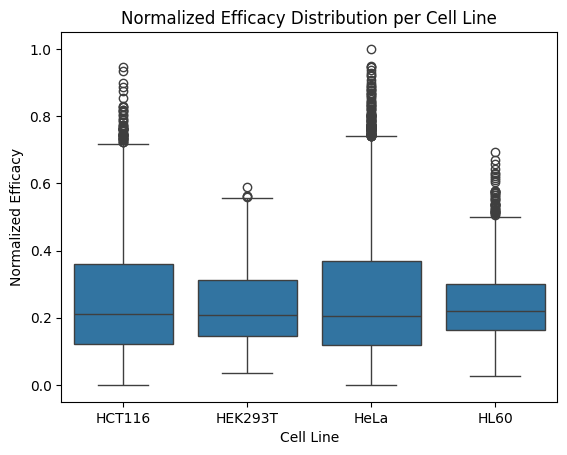

In [4]:
combined_df = pd.concat([
    hct116_df.assign(CellLine='HCT116'),
    hek293t_df.assign(CellLine='HEK293T'),
    hela_df.assign(CellLine='HeLa'),
    hl60_df.assign(CellLine='HL60')
])

sns.boxplot(data=combined_df, x='CellLine', y='Normalized efficacy')
plt.title('Normalized Efficacy Distribution per Cell Line')
plt.ylabel('Normalized Efficacy')
plt.xlabel('Cell Line')
plt.show()

In [5]:
'''
hct116_df.to_csv('hct116.csv', index=False)
hek293t_df.to_csv('hek293t.csv', index=False)
hela_df.to_csv('hela_df.csv', index=False)
hl60_df.to_csv('hl60_df.csv', index=False)
'''

"\nhct116_df.to_csv('hct116.csv', index=False)\nhek293t_df.to_csv('hek293t.csv', index=False)\nhela_df.to_csv('hela_df.csv', index=False)\nhl60_df.to_csv('hl60_df.csv', index=False)\n"

In [6]:
df=hek293t_df.copy()

In [7]:
df

,Chromosome,Start,End,Strand,sgRNA,Normalized efficacy
0,chr16,28602245,28602267,-,GGCTGCTTTACCCGCTGTGGGGG,0.323783
1,chr16,28602131,28602153,-,TCCGGGTTGGCCTTCCACTGGGG,0.349162
2,chr16,28600418,28600440,+,CAGCATCCTTCGGAAAGCTCTGG,0.280197
3,chr16,28602206,28602228,-,CGGTAGAAGCAGGTAGTCTGGGG,0.226491
4,chr16,28602121,28602143,+,CATCCCGCTGCCCCAGTGGAAGG,0.255358
...,...,...,...,...,...,...
2328,chr4,7045471,7045493,+,CGGCGGGCGCTTCACGCTCTGGG,0.485874
2329,chr4,7056389,7056411,+,CTGCAGCGGTACCGGCGAAACGG,0.512625
2330,chr4,7056698,7056720,-,AGGACTTTGTCCAGGTAGCTAGG,0.499876
2331,chr4,7056307,7056329,-,ACTCCTTGCATGACATGAACTGG,0.555058


In [8]:
df.shape

(2333, 6)

In [9]:
print("Max:", round(df['Normalized efficacy'].max(),3))
print("Min:", round(df['Normalized efficacy'].min(),3))

p1 = df['Normalized efficacy'].quantile(0.25)
p2 = df['Normalized efficacy'].quantile(0.50)
p3 = df['Normalized efficacy'].quantile(0.75)

print("25th percentile (Q1):", round(p1,3))
print("50th percentile (Median):", round(p2,3))
print("75th percentile (Q3):", round(p3,3))

Max: 0.59
Min: 0.037
25th percentile (Q1): 0.147
50th percentile (Median): 0.208
75th percentile (Q3): 0.311


In [10]:
df.describe()

,Start,End,Normalized efficacy
count,2.333000e+03,2.333000e+03,2333.000000
mean,6.469516e+07,6.469518e+07,0.237606
std,5.461508e+07,5.461508e+07,0.119823
min,7.045291e+06,7.045313e+06,0.036910
25%,2.958885e+07,2.958888e+07,0.146580
50%,7.033970e+07,7.033972e+07,0.208087
75%,7.035424e+07,7.035426e+07,0.310825
max,2.254497e+08,2.254497e+08,0.590267


In [11]:
df.dtypes

Chromosome              object
Start                    int64
End                      int64
Strand                  object
sgRNA                   object
Normalized efficacy    float64
dtype: object

In [12]:
df.info

<bound method DataFrame.info of      Chromosome     Start       End Strand                    sgRNA  \
0         chr16  28602245  28602267      -  GGCTGCTTTACCCGCTGTGGGGG   
1         chr16  28602131  28602153      -  TCCGGGTTGGCCTTCCACTGGGG   
2         chr16  28600418  28600440      +  CAGCATCCTTCGGAAAGCTCTGG   
3         chr16  28602206  28602228      -  CGGTAGAAGCAGGTAGTCTGGGG   
4         chr16  28602121  28602143      +  CATCCCGCTGCCCCAGTGGAAGG   
...         ...       ...       ...    ...                      ...   
2328       chr4   7045471   7045493      +  CGGCGGGCGCTTCACGCTCTGGG   
2329       chr4   7056389   7056411      +  CTGCAGCGGTACCGGCGAAACGG   
2330       chr4   7056698   7056720      -  AGGACTTTGTCCAGGTAGCTAGG   
2331       chr4   7056307   7056329      -  ACTCCTTGCATGACATGAACTGG   
2332       chr4   7056196   7056218      +  CAATCTGGTGCCAGCCTTCCTGG   

      Normalized efficacy  
0                0.323783  
1                0.349162  
2                0.280197  
3  

In [13]:
df.isnull().sum()

Chromosome             0
Start                  0
End                    0
Strand                 0
sgRNA                  0
Normalized efficacy    0
dtype: int64

In [14]:
df.duplicated().sum()

0

# Data Augmentation

In [15]:
nucleotides = ['A', 'C', 'G', 'T']

def generate_sgrnas(sgRNA):
    augmented = []
    for i in nucleotides:
        for j in nucleotides:
            if sgRNA[0] == i and sgRNA[1] == j:
                continue
            new_sgRNA = i + j + sgRNA[2:]
            if len(new_sgRNA) == len(sgRNA):
                augmented.append(new_sgRNA)
    return random.sample(augmented, min(3, len(augmented)))

augmented_rows = []

for _, row in df.iterrows():
    sgRNA = row['sgRNA']
    aug_sgrnas = generate_sgrnas(sgRNA)
    for i in aug_sgrnas:
        new_row = row.copy()
        new_row['sgRNA'] = i
        augmented_rows.append(new_row)
        
df_augmented = pd.DataFrame(augmented_rows)

In [16]:
df_augmented.shape

(6999, 6)

In [17]:
df_combined= pd.concat([df, df_augmented], ignore_index=True)

In [18]:
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
'''
df_augmented.to_csv('hek293t_augmented.csv', index=False)
df_combined.to_csv('hek293t_combined.csv', index=False)
'''


"\ndf_augmented.to_csv('hek293t_augmented.csv', index=False)\ndf_combined.to_csv('hek293t_combined.csv', index=False)\n"

In [20]:
df=df_combined.copy()

In [21]:
df.shape

(9332, 6)

# Feature Engineering

In [22]:
def gc_content(seq):
    gc_count = seq.count('G') + seq.count('C')
    return (gc_count / len(seq)) * 100

df['GC content']= df['sgRNA'].apply(gc_content)

In [23]:
print("Minimum GC Content: " , round(df['GC content'].min(),3))
print("Maximum GC Content: ", round(df['GC content'].max(),3))

Minimum GC Content:  21.739
Maximum GC Content:  91.304


In [24]:
df['Length'] = df['sgRNA'].apply(len)
df['Length'].value_counts()

Length
23    9332
Name: count, dtype: int64

In [25]:
df['sgRNA_noPAM'] = df['sgRNA'].apply(lambda x: x[:-3])
df['Length_noPAM'] = df['sgRNA_noPAM'].apply(len)

In [26]:
df['Length_noPAM'].value_counts()

Length_noPAM
20    9332
Name: count, dtype: int64

In [27]:
df.columns

Index(['Chromosome', 'Start', 'End', 'Strand', 'sgRNA', 'Normalized efficacy',
       'GC content', 'Length', 'sgRNA_noPAM', 'Length_noPAM'],
      dtype='object')

In [28]:
df=df.drop(['Length','Length_noPAM', 'sgRNA'], axis=1)
df

,Chromosome,Start,End,Strand,Normalized efficacy,GC content,sgRNA_noPAM
0,chr17,29653222,29653244,-,0.144676,52.173913,GTGCTAGCTTGAGAGCATTG
1,chr17,29679374,29679396,+,0.142441,56.521739,GGAATCCATGAGCCTGGACA
2,chr1,166838724,166838746,+,0.458122,43.478261,GGAGGAAATCATTGTGAGAA
3,chrX,70355019,70355041,+,0.243511,60.869565,GGTCATCACGTGTGAGCCAC
4,chr17,29661852,29661874,-,0.077469,39.130435,CTGTGTTTCAATTCAATACC
...,...,...,...,...,...,...,...
9327,chrX,70344894,70344916,+,0.402491,60.869565,AAAGGTGAAGCCCCCACCCA
9328,chrX,70344906,70344928,-,0.140627,47.826087,ATTCAATCTTCTCCTTGGGT
9329,chrX,70356339,70356361,-,0.207799,65.217391,ACGCGGCTCCTCATCTTCTG
9330,chrX,70348240,70348262,+,0.161761,47.826087,TCCTCTAACAATGGCACTTG


# One Hot Encoding

In [29]:
nucleotides = ['A', 'T', 'C', 'G']
encoder = OneHotEncoder(categories=[nucleotides], handle_unknown='ignore')
def one_hot_encoder(sequence):
    seq_arr = np.array(list(sequence)).reshape(-1, 1)
    return encoder.fit_transform(seq_arr).toarray()

result = df['sgRNA_noPAM'].apply(one_hot_encoder)
one_hot_arr = np.stack(result.to_numpy())  # shape: (samples, seq_len, 4)

joblib.dump(encoder, 'preprocessing/hek293t_encoder.pkl')

['preprocessing/hek293t_encoder.pkl']

# Data Preperation & Splitting with One Hot Encoding

In [30]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)
df=df.drop(['Chromosome'], axis=1)

features_df = df[['Chromosome_number', 'Strand','GC content']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train_df, X_feat_test_df, y_train, y_test = train_test_split(
    one_hot_arr, features_df, y, test_size=0.2, random_state=42
)

scaler_gc = MinMaxScaler()
X_feat_train_df['GC content'] = scaler_gc.fit_transform(X_feat_train_df[['GC content']])
X_feat_test_df['GC content'] = scaler_gc.transform(X_feat_test_df[['GC content']])
joblib.dump(scaler_gc, 'preprocessing/hek293t_gc_minmax_scaler.pkl')

X_num_train = X_feat_train_df.values
X_num_test = X_feat_test_df.values

# Saving models

In [31]:
def save_run(type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots):

    dir = os.path.join("/Users/LENOVO/OneDrive/Desktop/CRISPR PROJECT", "Best Performing Models/ hek293t")
    os.makedirs(dir, exist_ok=True)

    plot_paths = {}
    for name, fig in plots.items():
        path = os.path.join(dir, f"{name}_run{run_id}.png")
        fig.savefig(path)
        plt.close(fig)
        plot_paths[name] = path

    model_arch_path = None
    if model is not None:
        model_arch_path = os.path.join(dir, f"model_architecture_run_{run_id}.txt")
        with open(model_arch_path, "w", encoding="utf-8") as f:
            model.summary(print_fn=lambda x: f.write(x + "\n"))
    
    model_file_path = None
    if model is not None:
        model_file_path = os.path.join(dir, f"model_run_{run_id}.keras")
        model.save(model_file_path) 

    run = {
        "Model:": type,
        "Run_id": run_id,
        "Data": data,
        "Encoding Method": encoding_method,
        "Feature Engineering": feature_engineering,
        "Hyperparameters": hyperparameters,
        "Evaluation Metrics": metrics,
        "Plots": plot_paths,
        "Model Architecture": model_arch_path,
        "Model Path": model_file_path
    }

    json_path = os.path.join(dir, "runs.json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            all_runs = json.load(f)
    else:
        all_runs = []

    all_runs.append(run)

    with open(json_path, "w") as f:
        json.dump(all_runs, f, indent=2)
        
    print("Done")

# MLP with Attention

In [32]:
seq_len = 20        
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input')
x = Dense(d_model, use_bias=False)(seq_input)  # (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))                        
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x)

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)     

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)
attention_output = Flatten(name='gap')(x)    

x1 = Dense(256, kernel_initializer='he_normal')(attention_output)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(128, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(64, kernel_initializer='he_normal')(x1)
x1 = LeakyReLU()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 400,
    batch_size= 32
)


Epoch 1/400
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4959 - mae: 0.5349 - val_loss: 0.0689 - val_mae: 0.2075
Epoch 2/400
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1483 - mae: 0.3040 - val_loss: 0.0450 - val_mae: 0.1684
Epoch 3/400
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0872 - mae: 0.2313 - val_loss: 0.0337 - val_mae: 0.1459
Epoch 4/400
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0649 - mae: 0.2006 - val_loss: 0.0298 - val_mae: 0.1357
Epoch 5/400
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0532 - mae: 0.1806 - val_loss: 0.0256 - val_mae: 0.1267
Epoch 6/400
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0435 - mae: 0.1652 - val_loss: 0.0241 - val_mae: 0.1223
Epoch 7/400
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0358 - mae: 0.1498 - val_loss: 0.0215 - val_mae: 0.1151
Epoch 8/400
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0339 - mae: 0.1457 - val_loss: 0.0200 - val_mae: 0.1108
Epoch 9/400
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms

In [37]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [38]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.001
  RMSE     : 0.027
  MAE      : 0.019
  R2 Score : 0.95
  Spearman : 0.968


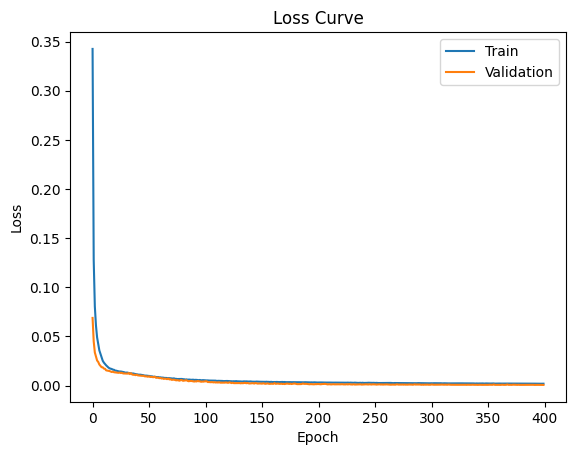

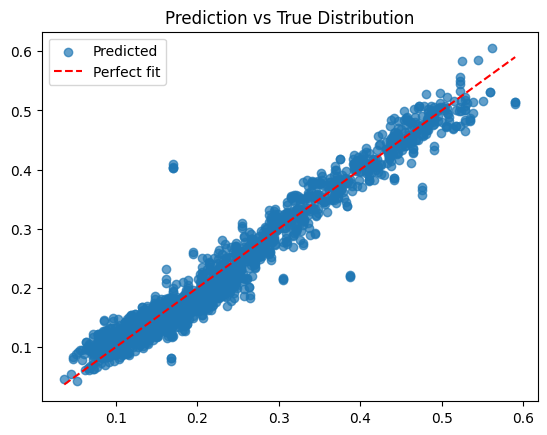

In [39]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [40]:
data= "Augmented Data"
encoding_method= 'One Hot Encoding'
feature_engineering= "With Feature Engineering"
run_id = 2
model_type = "MLP +ATTENTION"
hyperparameters = {
    "epochs": 400,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


In [41]:
def mc_confidence(model, X_seq, X_num, n_iter=30):
    predictions = []

    for _ in range(n_iter):
        prediction = model([X_seq, X_num], training=True).numpy()
        predictions.append(prediction)

    predictions = np.array(predictions)
    mean = predictions.mean(axis=0)
    std = predictions.std(axis=0)
    return mean, std

In [42]:
mean, std = mc_confidence(model, X_seq_test, X_num_test, n_iter=30)

print("Mean Prediction:", mean[:10].squeeze())
print("Confidence (± std):", std[:10].squeeze())

Mean Prediction: [0.16732474 0.21628706 0.21465635 0.18131754 0.14465412 0.25059205
 0.12003855 0.42346486 0.48829472 0.20281264]
Confidence (± std): [0.0299428  0.03591561 0.03993397 0.02771326 0.02768549 0.0425452
 0.017087   0.02886652 0.06073593 0.02542293]
